실험 세팅
- testset을 미리 떼 놓는다 (control 52 + ckd 52)
- 각 seed 마다 CKD는 동일한데, Control은 바뀌면서 학습한다. (no cross-validation)

In [1]:
import random
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import torch
from torch import nn, optim
from torch.nn import functional as F


from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, make_scorer, recall_score, precision_score, accuracy_score, roc_auc_score

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import cross_validate, StratifiedKFold

import xgboost as xgb

import shap
import time

import warnings
from sklearn.exceptions import ConvergenceWarning
import pickle
from joblib import dump, load

# ConvergenceWarning 경고를 무시
warnings.filterwarnings("ignore", category=ConvergenceWarning)

import os
os.environ["CUDA_VISIBLE_DEVICES"]= "7"

def set_seed(seed):
    # Set the random seed for PyTorch on CPU and GPU
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # If using multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Set the random seed for NumPy
    np.random.seed(seed)
    # Set the random seed for Python's built-in random module
    random.seed(seed)

In [2]:
"""FUNCTIONS"""

# test에 나머지 control sample 추가해서 idx 만 반환
def divide_testset(unbalanced_data, ratio):
    # train에서 ckd, control index 확인
    total_idx = unbalanced_data.index
    ckd_idx = unbalanced_data[unbalanced_data['onset_tight'] == 1].index        # 실제 ckd
    control_idx = unbalanced_data[unbalanced_data['onset_tight'] == 0].index    # 실제 control
    # print(control_idx, ckd_idx)

    # ckd 갯수와 동일하게 control idx sampling
    rng = np.random.default_rng(seed=0) 
    sampled_ckd_idx = pd.Index(rng.choice(ckd_idx, size=int(len(ckd_idx)*ratio), replace=False))
    sampled_control_idx = pd.Index(rng.choice(control_idx, size=len(sampled_ckd_idx), replace=False)) # test_ckd 갯수와 동일하게 sampling
    
    test_idx = sampled_ckd_idx.append(sampled_control_idx)
    train_idx = total_idx.difference(test_idx)

    # return 실제 ckd, 실제 ckd 갯수와 동일한 갯수의 subject, control_idx - ckd_idx
    return unbalanced_data.loc[train_idx], unbalanced_data.loc[test_idx]

### Oversampling
def oversampling(unbalanced_dataframe, seed):
    from imblearn.over_sampling import SMOTE
    smote = SMOTE(random_state=seed)
    temp = unbalanced_dataframe.drop(['RID'], axis=1)
    X_train, y_train = smote.fit_resample(temp, temp['onset_tight'])

    # X_train에는 RID, onset_3 없음.
    return X_train.drop(['onset_tight'], axis=1), y_train

### Undersampling
# test에 나머지 control sample 추가해서 idx 만 반환
def _under_sampling_idx(unbalanced_data, seed):
    # train에서 ckd, control index 확인
    ckd_idx = unbalanced_data[unbalanced_data['onset_tight'] == 1].index        # 실제 ckd
    control_idx = unbalanced_data[unbalanced_data['onset_tight'] == 0].index    # 실제 control
    # print(control_idx, ckd_idx)

    # ckd 갯수와 동일하게 control idx sampling
    """
    Control CKD 비율 조정
    """
    rng = np.random.default_rng(seed=seed) 
    sampled_control_idx = pd.Index(rng.choice(control_idx, size=len(ckd_idx), replace=False)) # ckd 갯수와 동일하게 sampling
    not_sampled_control_idx = control_idx.difference(sampled_control_idx)

    # 잘 sampling 되었는지 확인
    assert set(sampled_control_idx).issubset(set(control_idx))
    # print(len(sampled_control_idx))

    balanced_idx = sampled_control_idx.append(ckd_idx)

    # return 실제 ckd, 실제 ckd 갯수와 동일한 갯수의 subject, control_idx - ckd_idx
    return ckd_idx, sampled_control_idx, not_sampled_control_idx, balanced_idx

def undersampling(unbalanced_data, seed):
    a, b, c, d = _under_sampling_idx(unbalanced_data, seed)
    under_sampled_data = unbalanced_data.loc[d]
    X_undersampled = under_sampled_data.drop(['RID', 'onset_tight'], axis=1)
    y_undersampled = under_sampled_data['onset_tight']
    return X_undersampled, y_undersampled

def print_cv_results_ML(results_all_seed):
    # 모델별로 시드들의 평균과 표준편차를 구하는 부분
    results_summary = {}

    # 각 시드에 저장된 모델별 결과에 접근
    for seed in results_all_seed:
        for model_name in results_all_seed[seed]:
            if model_name not in results_summary:
                results_summary[model_name] = {
                    'recall': [],
                    'precision': [],
                    'accuracy': [],
                    'auc': [],
                    'recall_std': [],
                    'precision_std': [],
                    'accuracy_std': [],
                    'auc_std': []
                }
            # 각 시드의 성능 값을 추가
            results_summary[model_name]['recall'].append(results_all_seed[seed][model_name]['recall'][0])
            results_summary[model_name]['precision'].append(results_all_seed[seed][model_name]['precision'][0])
            results_summary[model_name]['accuracy'].append(results_all_seed[seed][model_name]['accuracy'][0])
            results_summary[model_name]['auc'].append(results_all_seed[seed][model_name]['auc'][0])
            results_summary[model_name]['recall_std'].append(results_all_seed[seed][model_name]['recall_std'][0])
            results_summary[model_name]['precision_std'].append(results_all_seed[seed][model_name]['precision_std'][0])
            results_summary[model_name]['accuracy_std'].append(results_all_seed[seed][model_name]['accuracy_std'][0])
            results_summary[model_name]['auc_std'].append(results_all_seed[seed][model_name]['auc_std'][0])

    # 모델별로 평균과 표준편차 계산
    for model_name in results_summary:
        print(f"Model: {model_name}")
        
        recall_mean = np.mean(results_summary[model_name]['recall'])
        recall_std = np.mean(results_summary[model_name]['recall_std'])
        
        precision_mean = np.mean(results_summary[model_name]['precision'])
        precision_std = np.mean(results_summary[model_name]['precision_std'])
        
        accuracy_mean = np.mean(results_summary[model_name]['accuracy'])
        accuracy_std = np.mean(results_summary[model_name]['accuracy_std'])
        
        auc_mean = np.mean(results_summary[model_name]['auc'])
        auc_std = np.mean(results_summary[model_name]['auc_std'])
        
        print(f"Recall Precision Accuracy AUC")
        print(f"{recall_mean:.4f}, {precision_mean:.4f}, {accuracy_mean:.4f}, {auc_mean:.4f}")
        print(f"{recall_std:.4f}, {precision_std:.4f}, {accuracy_std:.4f}, {auc_std:.4f}")    
        print("=" * 50)
        
def print_seed_results(results_all_seed):
    # 모델별로 시드들의 평균과 표준편차를 구하는 부분
    results_summary = {}

    # 각 시드에 저장된 모델별 결과에 접근
    for seed in results_all_seed:
        for model_name in results_all_seed[seed]:
            if model_name not in results_summary:
                results_summary[model_name] = {
                    'recall': [],
                    'precision': [],
                    'accuracy': [],
                    'auc': []
                }
            # 각 시드의 성능 값을 추가
            results_summary[model_name]['recall'].append(results_all_seed[seed][model_name]['recall'][0])
            results_summary[model_name]['precision'].append(results_all_seed[seed][model_name]['precision'][0])
            results_summary[model_name]['accuracy'].append(results_all_seed[seed][model_name]['accuracy'][0])
            results_summary[model_name]['auc'].append(results_all_seed[seed][model_name]['auc'][0])

    # 모델별로 평균과 표준편차 계산
    for model_name in results_summary:
        print(f"Model: {model_name}")
        
        recall_mean = np.mean(results_summary[model_name]['recall'])
        
        precision_mean = np.mean(results_summary[model_name]['precision'])
        
        accuracy_mean = np.mean(results_summary[model_name]['accuracy'])
        
        auc_mean = np.mean(results_summary[model_name]['auc'])
        
        print(f"Recall Precision Accuracy AUC")
        print(f"{recall_mean:.4f}, {precision_mean:.4f}, {accuracy_mean:.4f}, {auc_mean:.4f}")
        print("=" * 50)

def get_results(y_test, final_prediction, final_probabilities):
    cm = confusion_matrix(list(y_test), list(final_prediction))
    print(cm)
    tn, fn, tp, fp  = cm[0][0], cm[1][0], cm[1][1], cm[0][1]
    recall = tp / (fn + tp)
    precision = tp / (fp + tp)
    acc = (tp + tn) / (tn + fn + tp + fp)
    
    # Calculate AUC score
    auc = roc_auc_score(y_test, final_probabilities)
    
    print("Recall \t Precision \t Acc \t AUC")
    print(f"{np.round(recall, 4)} {np.round(precision, 4)} {np.round(acc, 4)} {np.round(auc, 4)}")
    return np.round(recall, 4), np.round(precision, 4), np.round(acc, 4), np.round(auc, 4)
    
def model_fitting(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model

def model_eval(fitted_model, X_test, y_test):
    model_prediction = fitted_model.predict(X_test)
    model_probabilities = fitted_model.predict_proba(X_test)[:, 1]
    model_score = fitted_model.score(X_test, y_test)
    print(f"Score with simple {fitted_model} model")
    print(0.5, np.round(model_score, 4))     # accuracy

    get_results(y_test, model_prediction, model_probabilities)

In [3]:
""" FUNCTIONS for DL """

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(MLP, self).__init__()
        self.hid1 = hidden_size1
        self.hid2 = hidden_size2
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.LeakyReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.LeakyReLU()
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.sigmoid = nn.Sigmoid()
        self.bn1 = nn.BatchNorm1d(num_features=hidden_size1)
        self.bn2 = nn.BatchNorm1d(num_features=hidden_size2)

    def forward(self, x):
        # breakpoint()
        x = self.fc1(x)
        x = self.bn1(self.relu1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.bn2(self.relu2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x
    
class MLP_1layer(nn.Module):
    def __init__(self, input_size, hidden_size1, output_size):
        super(MLP_1layer, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.LeakyReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_size1, output_size)
        self.sigmoid = nn.Sigmoid()
        self.bn1 = nn.BatchNorm1d(num_features=hidden_size1)

    def forward(self, x):
        # breakpoint()
        x = self.fc1(x)
        x = self.bn1(self.relu1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x
    
from torch.utils.data import Dataset, DataLoader, random_split

class TabularDataset(Dataset) :
    def __init__(self, X , y) :
        self.X = X
        self.y = y
    def __len__(self) :
        return len(self.X)
    def __getitem__(self,idx) :
        if isinstance(idx, torch.Tensor):
            idx = idx.tolist()
        return [self.X.iloc[idx].values, self.y.iloc[idx]]      # X가 Dataframe일 때
        # return [self.X[idx], self.y[idx]]       # X가 array일 때
        
def normalizing(X_train, X_test):
    # pd.Dataframe -> pd.Dataframe
    columns = X_train.columns
    
    wei_train_scaler = StandardScaler()
    # wei_train_scaler =MinMaxScaler()
    X_train_scaled = wei_train_scaler.fit_transform(X_train)
    X_test_scaled = wei_train_scaler.transform(X_test)
    
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=columns, index=X_train.index)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=columns, index=X_test.index)
    
    return X_train_scaled, X_test_scaled

def metric(y_test, y_pred):  # label, pred
    y_test = y_test.cpu().detach().numpy()
    y_pred = y_pred.cpu().detach().numpy()
    y_pred = y_pred.flatten()
    y_pred = np.where(y_pred > 0.5, 1, 0)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Calculate recall, precision, accuracy
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=1)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Calculate AUC of ROC
    auc = roc_auc_score(y_test, y_pred)
    
    # Return all metrics
    return recall, precision, accuracy, auc, cm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train(model, optimizer, criterion, epoch, train_loader, l1_lambda=0.1):
    t = time.time()
    model.train()
    for train_input, train_label in train_loader:
        train_input = train_input.cuda(device)
        train_label = train_label.cuda(device)
        optimizer.zero_grad()
        
        # breakpoint()
        output = model(train_input)
        loss_train = criterion(output.squeeze(), train_label)
            
        if l1_lambda > 0:
            l1_norm = sum(p.abs().sum() for p in model.parameters())    # l1 norm
            loss_train += l1_lambda * l1_norm
    
        recall_train, precision_train, acc_train, auc_train, cm_train = metric(train_label, output)
        loss_train.backward()
        optimizer.step()
        
        return recall_train, precision_train, acc_train, auc_train, cm_train

def show_cm(cm):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

def test_CV(model, criterion, X_test, y_test):
    model.eval()
    with torch.no_grad():
        # 데이터를 GPU로 이동
        X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
        y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device)
        
        # 모델 예측
        output_test = model(X_test_tensor)
        loss_test = criterion(output_test.squeeze(), y_test_tensor)
        
        # 정확도, 재현율, 정밀도, AUC 등의 메트릭 계산
        recall_test, precision_test, acc_test, auc_test, cm_test = metric(y_test_tensor, output_test)
        
        # 결과 로그 출력
        print("=== Test set results ===")
        print("loss, recall, precision, acc, AUC")
        print("{:.4f}, {:.4f}, {:.4f}, {:.4f}, {:.4f}".format(loss_test.item(), recall_test, precision_test, acc_test, auc_test))
        output_test = output_test.cpu().detach()
        
        # show_cm(cm_test)
        
        return output_test, loss_test.item(), recall_test, precision_test, acc_test, auc_test, cm_test

### Use Adjusted mean food

In [4]:
root_path = "/home/user19/pnu_ckd/hexa_preprocessing_after95/0911_dl_models/data/0922_data"
total = pd.read_csv(f"{root_path}/0922_basic_food_adjusted_mean.csv")
basic = pd.read_csv(f"{root_path}/0922_basic_only.csv")
food = pd.read_csv(f"{root_path}/0922_food_adjusted_mean_only.csv")

In [5]:
total_with_valuable_food_col = ['RID', 'CT1_SEX', 'CT1_AGE', 'CT1_eGFR', 'imp_CT1_SBP', 'imp_CT1_BMI', 'CT1_HB', 'Imp_CT1_ALBUMIN', 'CT1_TCHL', 'imp_new_EDU',
       'imp_new_INCOME', 'imp_new_DRINK', 'imp_new_SMOKE', 'new_CT1_gohyeol', 'CT1_dangnyo', 'CT1_simhyeol', 'onset_tight', 
       'F02_Mean_res', 'F11_Mean_res', 'F01_Mean_res', 'F21_Mean_res', 'F12_Mean_res', 'F04_Mean_res', 'F13_Mean_res']

# valuable_food_col = ['RID', 'onset_tight', 'F02_Mean_res', 'F11_Mean_res', 'F01_Mean_res', 'F21_Mean_res', 'F12_Mean_res', 'F04_Mean_res', 'F13_Mean_res']
valuable_food_col = ['RID', 'onset_tight', 'F02_Mean_res', 'F11_Mean_res', 'F01_Mean_res', 'F21_Mean_res', 'F12_Mean_res', 'F04_Mean_res', 'F13_Mean_res', 'F06_Mean_res', 'F17_Mean_res', 'F16_Mean_res']

total_cols = ['CT1_SEX', 'CT1_AGE', 'CT1_eGFR', 'imp_CT1_SBP', 'imp_CT1_BMI', 'CT1_HB', 'Imp_CT1_ALBUMIN', 'CT1_TCHL', 'imp_new_EDU',
       'imp_new_INCOME', 'imp_new_DRINK', 'imp_new_SMOKE', 'new_CT1_gohyeol', 'CT1_dangnyo', 'CT1_simhyeol',
       'Rice', 'Other grains', 'Noodles and dumplings', 'Wheat flour and bread', 'Potatoes',
    'Sweets', 'Soybean pastes', 'Bean, tofu, and soymilk', 'Nuts', 'Vegetables',
    'Kimchi', 'Mushroom', 'Fruits', 'Red meat and its products', 'White meat and its products',
    'Eggs', 'Fish and shellfish', 'Seaweeds', 'Milk and dairy products', 'Beverage', 'Coffee and tea']

basic_cols = ['CT1_SEX', 'CT1_AGE', 'CT1_eGFR', 'imp_CT1_SBP', 'imp_CT1_BMI', 'CT1_HB', 'Imp_CT1_ALBUMIN', 'CT1_TCHL', 'imp_new_EDU',
       'imp_new_INCOME', 'imp_new_DRINK', 'imp_new_SMOKE', 'new_CT1_gohyeol', 'CT1_dangnyo', 'CT1_simhyeol']

food_cols = ['Rice', 'Other grains', 'Noodles and dumplings', 'Wheat flour and bread', 'Potatoes',
    'Sweets', 'Soybean pastes', 'Bean, tofu, and soymilk', 'Nuts', 'Vegetables',
    'Kimchi', 'Mushroom', 'Fruits', 'Red meat and its products', 'White meat and its products',
    'Eggs', 'Fish and shellfish', 'Seaweeds', 'Milk and dairy products', 'Beverage', 'Coffee and tea']

total_valfood = total[total_with_valuable_food_col]
valfood = food[valuable_food_col]

### seed 마다 Control 만 바뀌고, no-cross validation 실험 결과

- 5 seed 평균

In [6]:
print(total.shape, basic.shape, food.shape, total_valfood.shape, valfood.shape)

(57231, 38) (57231, 17) (57231, 23) (57231, 24) (57231, 12)


##### Basic only

In [7]:
# total, basic, food, total_valfood, valfood
a, b = divide_testset(basic, ratio=0.1)

# test
y_test = b['onset_tight']
X_test = b.drop(['RID', 'onset_tight'], axis=1)

For undersampling dataset!!!
(946, 15) (946,)
undersampling dataset loaded and scaled
X_train :: (946, 15), y_train :: (946,)
=====Optimization Finished!=====
Total time elapsed: 9.7186s
Model weight is saved to shap_figs_1224_morecontrol/basic_under_seed42/MLP/MLP_weights.joblib!!
Explainer for MLP is saved to shap_figs_1224_morecontrol/basic_under_seed42/MLP/MLP_explainer.joblib!!
SHAP values of MLP model on seed 42, is saved to shap_figs_1224_morecontrol/basic_under_seed42/MLP/shap_values_MLP.pk.
(104, 15)
=== Test set results ===
loss, recall, precision, acc, AUC
0.4247, 0.8846, 0.8519, 0.8654, 0.8654


For undersampling dataset!!!
(946, 15) (946,)
undersampling dataset loaded and scaled
X_train :: (946, 15), y_train :: (946,)
=====Optimization Finished!=====
Total time elapsed: 8.9802s
Model weight is saved to shap_figs_1224_morecontrol/basic_under_seed59/MLP/MLP_weights.joblib!!
Explainer for MLP is saved to shap_figs_1224_morecontrol/basic_under_seed59/MLP/MLP_explainer.joblib!!

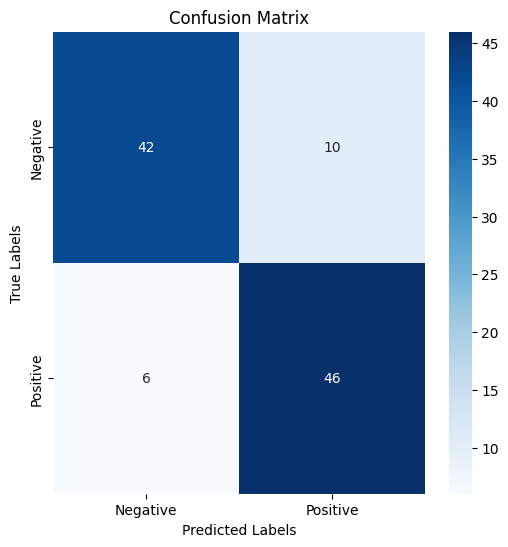

In [8]:
""" Total Dataset ( Basic Only ) """

cms_per_seed = []
recall_per_seed = []
precision_per_seed = []
acc_per_seed = []
auc_per_seed = []
shap_per_seed = []

for seed in [42, 59, 63, 79, 101]:    
# for seed in [42]:    
    set_seed(seed)
    dataset_name = "basic_under"
    shap_fig_dir = f"shap_figs_1224_morecontrol/{dataset_name}_seed{seed}"
    os.makedirs(shap_fig_dir, exist_ok=True)  # 폴더가 없으면 생성
    
    datas = {"original":(), "undersampling":(), "oversampling":()}

    datas['undersampling'] = undersampling(a, seed=seed)        # eGFR 만을 빼면 성능이 줄어든다..
    datas['oversampling'] = oversampling(a, seed=seed)
    y_tight3_foodsum_train = a['onset_tight']
    X_tight3_foodsum_train = a.drop(['RID', 'onset_tight'], axis=1)
    datas['original'] = (X_tight3_foodsum_train, y_tight3_foodsum_train)
    
    for data in ['undersampling']:
        print(f"For {data} dataset!!!")
        X_train, y_train = datas[data]
        print(X_train.shape, y_train.shape)
        # print(y_train)
        
        print(f"{data} dataset loaded and scaled")
        print(f"X_train :: {X_train.shape}, y_train :: {y_train.shape}")
        
        X_train_scaled, X_test_scaled = normalizing(X_train, X_test)
        X_train_scaled, y_train, X_test_scaled, y_test = X_train_scaled.astype('float32'), y_train.astype('float32'), X_test_scaled.astype('float32'), y_test.astype('float32')
        
        trainset = TabularDataset(X_train_scaled, y_train)
        testset = TabularDataset(X_test_scaled, y_test)
        trainloader = DataLoader(trainset, batch_size=1000, shuffle=True)
        testloader = DataLoader(testset, batch_size=1000, shuffle=False)
        
        model = MLP(input_size=X_train.shape[1], hidden_size1=64, hidden_size2=16, output_size=1).to(device)
        
        optimizer = optim.Adam(model.parameters(), lr=0.1, weight_decay=0.1)
        criterion = nn.BCELoss()
        # Train model
        t_total = time.time()
        for epoch in range(200):
            train(model, optimizer, criterion, epoch, trainloader, l1_lambda=0.)
        print("=====Optimization Finished!=====")
        print("Total time elapsed: {:.4f}s".format(time.time() - t_total))
        
        # shap
        X_train_scaled_torch = torch.from_numpy(X_train_scaled.values).to(device).float()
        X_test_scaled_torch = torch.from_numpy(X_test_scaled.values).to(device).float()
        
        # save : model, explainer, shap values, summary plot
        # model
        save_path_model = os.path.join(shap_fig_dir, f"MLP")
        os.makedirs(save_path_model, exist_ok=True)
        save_path_model_weights = os.path.join(save_path_model, f"MLP_weights.joblib")
        dump(model, save_path_model_weights)
        print(f"Model weight is saved to {save_path_model_weights}!!")
        
        # explainer
        explainer_shap = shap.DeepExplainer(model, X_train_scaled_torch)
        save_path_explainer = os.path.join(save_path_model, f"MLP_explainer.joblib")
        dump(explainer_shap, save_path_explainer)
        print(f"Explainer for MLP is saved to {save_path_explainer}!!")
        
        # shap 값 계산 및 저장
        shap_val = explainer_shap.shap_values(X_test_scaled_torch, check_additivity=False)
        shap_values_save_path = os.path.join(save_path_model, f"shap_values_MLP.pk")
        with open(shap_values_save_path, 'wb') as f:
            pickle.dump(shap_val, f)
        print(f"SHAP values of MLP model on seed {seed}, is saved to {shap_values_save_path}.")
        shap_per_seed.append(shap_val)
        print(shap_val.shape)
        
        # Summary plot 그리기 및 저장
        plt.figure()
        save_path_png = os.path.join(save_path_model, f"summary_plot, model_MLP.png")

        shap.summary_plot(shap_val, X_test.values, feature_names=total_cols, show=False)
        plt.title(f"Summary plot for of MLP")
        plt.savefig(save_path_png)
        plt.close()
        
        outputs, _, recall_test, precision_test, acc_test, auc_test, cm_test = test_CV(model, criterion, X_test_scaled, y_test)
        cms_per_seed.append(cm_test)
        recall_per_seed.append(recall_test)
        precision_per_seed.append(precision_test)
        acc_per_seed.append(acc_test)
        auc_per_seed.append(auc_test)
        print()
        print()
        print("=" * 30)
        
cms_per_seed = np.array(cms_per_seed)
print("recall precision acc auc")
print(f"{round(np.mean(recall_per_seed), 4)}, {round(np.mean(precision_per_seed), 4)}, {round(np.mean(acc_per_seed), 4)}, {round(np.mean(auc_per_seed), 4)}")
mean_matrix = np.round(np.mean(cms_per_seed, axis=0)).astype(int)
show_cm(mean_matrix)

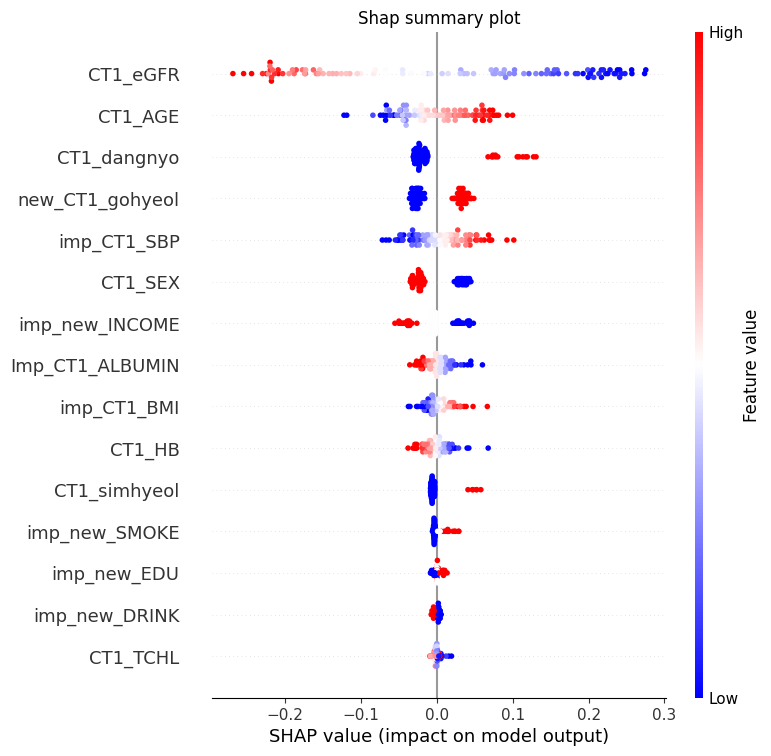

In [12]:
# 5개모델의 평균 shap value를 가지고 summary plot 그림.
shap_per_seed_mean = np.mean(np.array(shap_per_seed), axis=0)

plt.figure()
shap.summary_plot(shap_per_seed_mean, X_test.values, feature_names=basic_cols,
                  cmap='bwr', show=False)
plt.title("Shap summary plot")
plt.show()